# PyTorch EO Semantic Segmentation Example
## Step 3: Training of the SegNet model

This notebook provides an EO deep learning example for semantic segmentation, using a SegNet network. It was trained on Sentinel-2 data (as features) and crop types from the Dutch LPIS (2018) for a small study area in The Netherlands.

Originally this notebook has been used to train the model on Google Colab (using a GPU). It is provided here as reference material, with the original output included. Preparing adequate input data for this type of deep learning model is a separate (and time-consuming) step, which is not described in this notebook.


In [1]:
# connect to Google Drive for access to the training data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Note: To see a folder that is shared with you, you need to create
#   a shortcut for it on your Google Drive before it you can access
#   it here in CoLab.

# expect a data / inputs folder with hdf5 files containing archived
# input data created from train and test images.
!ls '/content/drive/MyDrive/AI_WENR/data/inputs'

crops_training_data_s2_10m_2018seasons_224x224x28_155cat.hdf5
crops_training_data_s2_10m_2018seasons_224x224x28_76cat.hdf5


In [3]:
# setup paths to the data (on connected Google Drive)
import os
import h5py

# construct the paths to the training data
content_root_folder = os.path.join('/content', 'drive', 'MyDrive', 'AI_WENR', 'data')

# HDF5 file with input data
hdf5_file = os.path.join(content_root_folder, 'inputs', 'crops_training_data_s2_10m_2018seasons_224x224x28_76cat.hdf5')

# TODO should move encodings info into the HDF5 archive file

# file with information about the encoding used for the labels
codes_folder = os.path.join(content_root_folder, 'codes')
codes_file = os.path.join(codes_folder, 'cell_value_to_crop_info_76_classes.csv')

In [1]:
# setup paths to the data (on local drive)
import os
import h5py

content_root_folder = os.path.join('..', 'data')
hdf5_file = os.path.join(content_root_folder, 'archives', 'crops_training_data_s2_10m_2018seasons_224x224x28_76cat.hdf5')

codes_folder = os.path.join(content_root_folder, 'raw')
codes_file = os.path.join(codes_folder, 'cell_value_to_crop_info_76_classes.csv')

In [2]:
# open the input file
data_file = h5py.File(hdf5_file, "r")

print("(Attribute, Value:)");
for item in data_file.attrs.items():
    print(item);

train_obs = data_file['train_observation'][:]
train_gt = data_file['train_groundtruth'][:]
test_obs = data_file['test_observation'][:]
test_gt = data_file['test_groundtruth'][:]
n_train = train_obs.shape[0]
n_test = test_obs.shape[0]

print("%d tiles for training, %d tiles for testing" % (n_train, n_test))

(Attribute, Value:)
('description', 'This data set is intended for training deep learning models for crop classification.')
('ground_truth', 'Encoded crop types for fields according to the RVO registration in 2018.')
('ground_truth_shape', '1,224,224; 76 classes, int16')
('observations', '4 Bands (blue, green, red, nir) of 7 seasonal Sentinel 2 images, from 2018.')
('observations_shape', '28,224,224; scaled [0-1], float32')
('spatial_extent', 'Sample area around the Noordoost polder in The Netherlands.')
('spatial_resolution', '10x10m grid cells')
('title', 'Crop classification training data set')
151 tiles for training, 43 tiles for testing


In [5]:
# local install required libraries (only on Google Colab)
!pip install torchnet mock

     |████████████████████████████████| 676 kB 8.5 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29741 sha256=d13e23ad39f0e3c9bd774e5d831b308e83eca1d77ff6b8e0bc6fa2fbc8499b36
  Stored in directory: /root/.cache/pip/wheels/93/17/b3/86db1d93e9dae198813aa79831b403e4844d67986cf93894b5
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=a578aa2e2e03e53f9ae4ccf2536944c1b0d044d5343d21a06ad839be6ad597d4
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5710 sha256=e038dfdf6634a1756634cd6ab643bcaed4a80cc1aece204d700d0b229d85ef2e
  Stored in directory: /root/.cache/pip/wheels/ac/5c/3a/a80e1c65880945c71fd833408cd1e9a8cb7e2f8f37620bb75b
Successfully built torchnet visdom torchfile


In [3]:
# check if we can import all needed of PyTorch
import torch
import torchnet as tnt
import torch.nn.functional as nnf
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm

In [19]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    gpu_available = 1
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Reserved:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
else:
    gpu_available = 0

Using device: cpu



In [5]:
# some other standard imports that are needed
import random
import functools
from functools import partial
import mock
import math
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# read encodings data
encodings_df = pd.read_csv(codes_file)
class_names = encodings_df.sort_values(['cell_value'])['crop_name']
print(class_names.shape)

# create a colormap for viewing the ground truth images
# use one of these: viridis, plasma, inferno, magma
# or gist_earth, gist_rainbow, gist_ncar
max_cell_value = encodings_df['cell_value'].max()
print(max_cell_value)

class_cm = cm.get_cmap('gist_ncar', max_cell_value)

(76,)
76


In [20]:
# define a data loader

def augment(obs, gt):
  """the augmentation functions
  """
  # sigma, clip= 0.01, 0.03 
  # use np.clip to clip and np.random.randn to generate gaussian noise
  # obs = obs + np.clip(#TODO).astype(np.float32)
  # noise = np.random.normal(loc=0, scale=1, size=obs.shape)
  # obs = obs + np.clip(noise, 0.01, 0.03).astype(np.float32)

  #random rotation 0 90 180 270 degree
  n_turn = np.random.randint(0,3)
  for turn in range(n_turn):
    obs = np.rot90(obs, axes=(1,2)).copy()
    gt = np.rot90(gt, axes=(0,1)).copy()

  return obs, gt


def tile_loader(tile_index, train = True, cuda = gpu_available):
  """
  load a tile and returns the observation and associated ground truth
  INPUT:
  tile_index = int, index of the tile
  train = bool, train = True iff in the train set
  cuda = int, cuda = 1 if using GPU, 0 for CPU only
  OUTPUT
  obs, float array containing the observation
  gt, uint8 array, containing the pixels semantic labels  
  """
  if train:
    obs = train_obs[tile_index,:,:,:].transpose(2,0,1) #put channels first
    gt = train_gt[tile_index,:,:]
  else:
    obs = test_obs[tile_index,:,:,:].transpose(2,0,1)
    gt = test_gt[tile_index,:,:]
    
  if train: #augmentation - for training only
    obs, gt = augment(obs, gt)   
  
  # create torch wrapper
  obs = torch.from_numpy(obs)
  gt = torch.from_numpy(gt)
  
  if cuda: #put on GPU memory
    obs = obs.cuda()
   
  return obs, gt.long() #ground truth must have long int type

# create train and test dataset with ListDataset
test_set  = tnt.dataset.ListDataset(list(range(n_test)),functools.partial(tile_loader, train=False))
train_set = tnt.dataset.ListDataset(list(range(n_train)),functools.partial(tile_loader, train=True))

In [32]:
# functions used for visualization

def view_rgb(tile, ax = None):
  """ show the rgb values of the tile in figure ax"""
  if ax == None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
  tile_corrected = np.minimum(np.maximum(tile[:3,:,], 0), 1) # normalization
  tile_corrected *= 5.0
  ax.imshow(tile_corrected.transpose(0,2).transpose(0,1)) # put channels back as dim 3
  plt.axis('off')
  
def view_infrared(tile, ax = None):
  """ show the infrared tile in figure ax"""
  if ax == None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
  tile_corrected = np.minimum(np.maximum(tile[3,:,:], 0), 1) # normalization
  ax.imshow(tile_corrected, cmap='hot')
  plt.axis('off')

def view_labels(label, ax = None, mask = None,):
  """ show the ground truth with a colorcode corresponding to labels"""
  if ax == None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
  if mask is not None:
    label[mask] = 0
  # n_pixel = label.shape[1]
  ax.imshow(label, cmap=class_cm)
  plt.axis('off')
  
def view_error(pred, gt, ax = None):
  """ show the error between pred and gt with colorcode:
 green when 'gt'='pred', red when 'gt'!='pred' and black
 when unnannotated (gt = 0)"""
  if ax == None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
  n_pixel = gt.shape[1]
  colors = np.zeros((n_pixel,n_pixel,3))
  colors[np.where(pred == gt.squeeze())] = [0, 1, 0] # correct prediction
  colors[np.where(pred != gt.squeeze())] = [1, 0, 0] # error
  colors[np.where(gt.squeeze() == 0)] = [0, 0, 0]   # unannotated 
  ax.imshow(colors)
  plt.axis('off')
  
def viewer(n_shown = 3, category = 'cig', train = True, model = None, use_mask = False):
  """ plot 'n_shown' random tiles train/test set with the following visuals:
  if 'c' in category : rgb color
  if 'i' in category : infrared
  if 'g' in category : ground truth
  if 'p' in category : prediction
  if 'e' in category : error
  Note that for 'p' or 'e' you need to add a trained model as input
  
  """
  n_category = len(category) # number of types of image to show
  fig = plt.figure(figsize=(n_category * 5, n_shown * 5)) # adapted dimension
  
  subplot_index = 1 # keep track of current subplot
  
  # chose random tiles
  tile_indices = np.random.choice(n_train, n_shown) if train \
  else np.random.choice(n_test, n_shown)
  
  for tile_index in tile_indices:
    
    tile, gt = tile_loader(tile_index, train = train, cuda=0)
    
    if 'c' in category:
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category : 
        ax.set(title='RGB')
      view_rgb(tile, ax = ax)
      subplot_index += 1
    if 'i' in category:  
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category : 
        ax.set(title='Infrared')
      view_infrared(tile, ax = ax)
      subplot_index += 1
    if 'g' in category:  
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category : 
        ax.set(title='Ground Truth')
      view_labels(gt, ax = ax)
      subplot_index += 1
    if 'p' in category:  
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category : 
        ax.set(title='Prediction')
      if gpu_available:
        pred = model(tile[None,:,:,:].cuda()).cpu().argmax(1).squeeze()
      else:
        pred = model(tile[None,:,:,:]).argmax(1).squeeze()
      if use_mask:
        pred[gt==0] = 0
      view_labels(pred, ax = ax)
      subplot_index += 1  
    if 'e' in category: 
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category : 
        ax.set(title='Error')
      if gpu_available:
        pred = model(tile[None,:,:,:].cuda()).cpu().argmax(1).squeeze()
      else:
        pred = model(tile[None,:,:,:]).argmax(1).squeeze()
      view_error(pred, gt, ax = ax)
      subplot_index += 1
  plt.show()

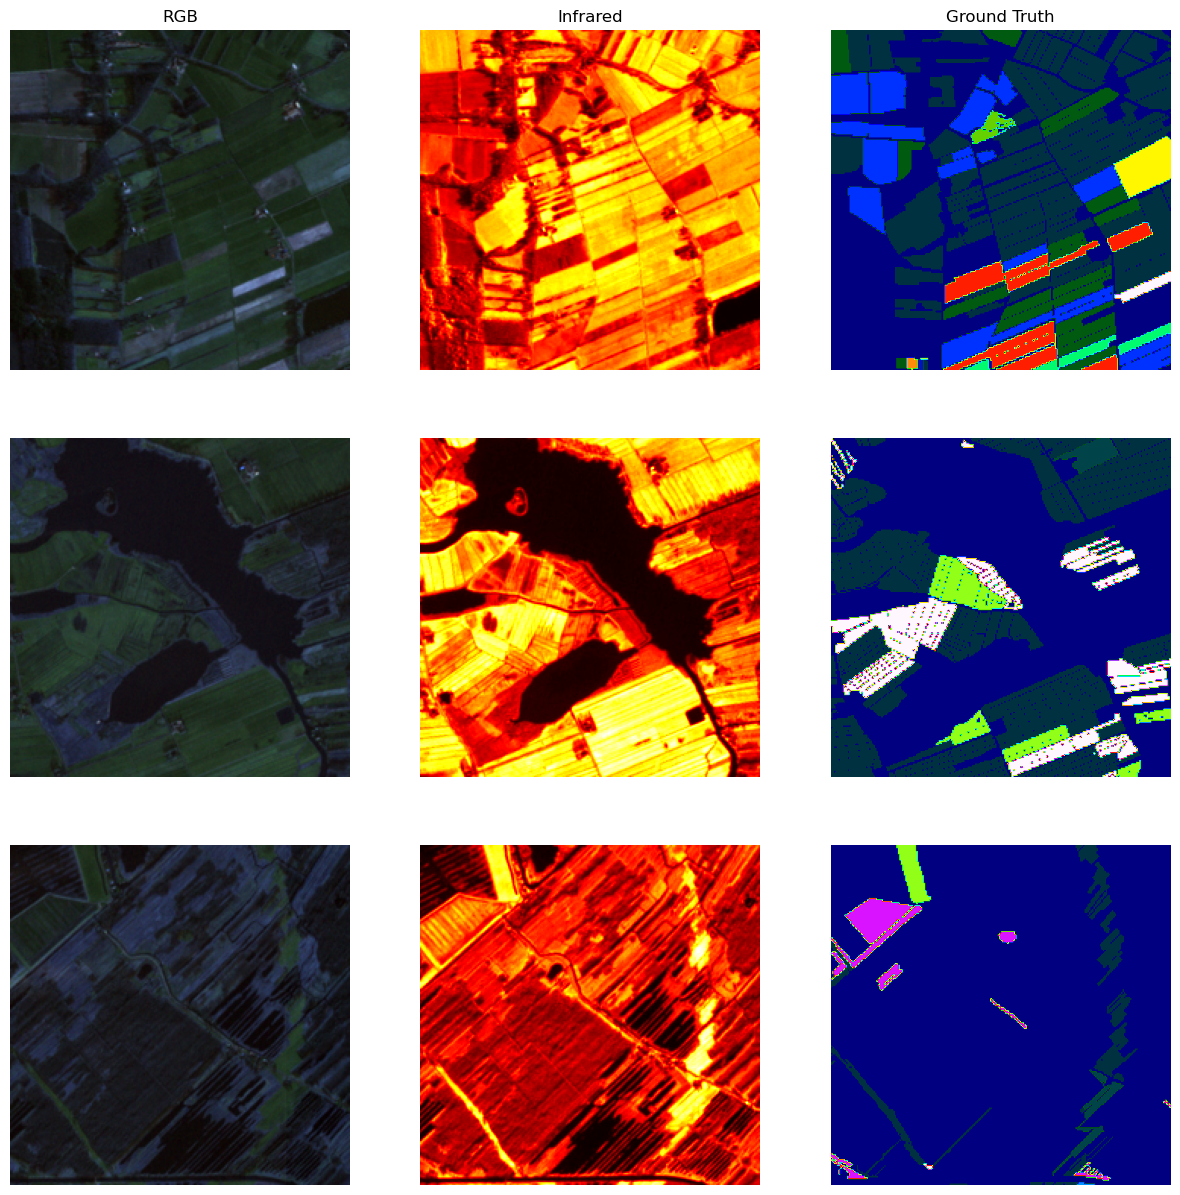

In [33]:
# show a few tiles (c=rgb, i=infrared, g=ground_truth)
viewer(3, 'cig')

In [26]:
class ConfusionMatrix:
  def __init__(self, n_class, class_names):
    self.CM = np.zeros((n_class, n_class))
    self.n_class = n_class
    self.class_names = class_names
  
  def clear(self):
    self.CM = np.zeros((self.n_class, self.n_class))
    
  def add_batch(self, gt, pred):
    self.CM += confusion_matrix(gt, pred, labels = list(range(self.n_class)))
    
  def overall_accuracy(self): # percentage of correct classification
    return (np.trace(self.CM) / np.sum(self.CM))*100

  def class_IoU(self, show = 1):
    ious = np.full(self.n_class, 0.)
    for i_class in range(self.n_class):
      sum = 0.0
      for j in range(self.n_class):
        if (j != i_class):
          sum += self.CM[i_class,j] + self.CM[j,i_class]
      ious[i_class] = self.CM[i_class,i_class] / (self.CM[i_class,i_class] + sum)
    
    if show:
      print('  |  '.join('{} : {:3.2f}%'.format(name, 100*iou) for name, iou in zip(self.class_names,ious)))
    
    # do not count classes that are not present in the dataset in the mean IoU
    return 100*np.nansum(ious) / (np.logical_not(np.isnan(ious))).sum()

In [34]:
# define a SegNet architecture

class SegNet(nn.Module):
  """
  EncoderDecoder network for semantic segmentation
  """
  
  def __init__(self, n_channels, encoder_conv_width, decoder_conv_width, n_class, cuda = 0):
    """
    initialization function
    n_channels, int, number of input channel
    encoder_conv_width, int list, size of the feature maps depth for the encoder after each conv
    decoder_conv_width, int list, size of the feature maps depth for the decoder after each conv
    n_class = int,  the number of classes
    """
    super(SegNet, self).__init__() # necessary for all classes extending the module class
    
    assert((encoder_conv_width[3] == encoder_conv_width[5]) \
     and (encoder_conv_width[1] == decoder_conv_width[1]))
    
    self.maxpool=nn.MaxPool2d(2,2,return_indices=True) # maxpooling layer
    self.unpool=nn.MaxUnpool2d(2,2) # unpooling layer
    
    # encoder
    self.c1 = nn.Sequential(
        nn.Conv2d(n_channels, encoder_conv_width[0], 3, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(encoder_conv_width[0]),
        nn.ReLU(True))
    self.c2 = nn.Sequential(
        nn.Conv2d(encoder_conv_width[0], encoder_conv_width[1], 3, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(encoder_conv_width[1]),
        nn.ReLU(True))
    self.c3 = nn.Sequential(
        nn.Conv2d(encoder_conv_width[1], encoder_conv_width[2], 3, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(encoder_conv_width[2]),
        nn.ReLU(True))
    self.c4 = nn.Sequential(
        nn.Conv2d(encoder_conv_width[2], encoder_conv_width[3], 3, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(encoder_conv_width[3]),
        nn.ReLU(True))
    self.c5 = nn.Sequential(
        nn.Conv2d(encoder_conv_width[3], encoder_conv_width[4], 3, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(encoder_conv_width[4]),
        nn.ReLU(True))
    self.c6 = nn.Sequential(
        nn.Conv2d(encoder_conv_width[4], encoder_conv_width[5], 3, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(encoder_conv_width[5]),
        nn.ReLU(True))

    # decoder
    self.c7=nn.Sequential(
        nn.Conv2d(encoder_conv_width[5] + encoder_conv_width[3], decoder_conv_width[0], 3, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(decoder_conv_width[0]),
        nn.ReLU(True))
    self.c8=nn.Sequential(
        nn.Conv2d(decoder_conv_width[0], decoder_conv_width[1], 3, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(decoder_conv_width[1]),
        nn.ReLU(True))       
    self.c9=nn.Sequential(
        nn.Conv2d(encoder_conv_width[1] + decoder_conv_width[1], decoder_conv_width[2], 3, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(decoder_conv_width[2]),
        nn.ReLU(True))
    self.c10=nn.Sequential(
        nn.Conv2d(decoder_conv_width[2], decoder_conv_width[3], 3, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(decoder_conv_width[3]),
        nn.ReLU(True)) # for regularisation could add dropout here, nn.Dropout()
    
    # final classifying layer
    self.classifier=nn.Conv2d(decoder_conv_width[3], n_class, 3, padding=1, padding_mode='reflect')

    # weight initialization
    self.c1[0].apply(self.init_weights)
    self.c2[0].apply(self.init_weights)
    self.c3[0].apply(self.init_weights)
    self.c4[0].apply(self.init_weights)
    self.c5[0].apply(self.init_weights)
    self.c6[0].apply(self.init_weights)
    self.c7[0].apply(self.init_weights)
    self.c8[0].apply(self.init_weights)
    self.c9[0].apply(self.init_weights)
    self.c10[0].apply(self.init_weights)
    self.classifier.apply(self.init_weights)
    
    if cuda: # put the model on the GPU memory
      self.cuda()
    
  def init_weights(self,layer): # gaussian init for the conv layers
    nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
    
  def forward(self,input):
    """
    the function called to run inference
    """  
    # encoder
    #level 1
    x1 = self.c2(self.c1(input))
    x2, indices_a_b = self.maxpool(x1)
    #level 2
    x3= self.c4(self.c3(x2))
    x4, indices_b_c =self.maxpool(x3)
    #level 3
    x5 = self.c6(self.c5(x4))
    # decoder
    #level 2       
    y4 = self.unpool(x5, indices_b_c, x2.size())
    y3 = self.c8(self.c7(torch.cat((y4,x3), 1)))
    # level 1       
    y2 = self.unpool(y3, indices_a_b, x1.size())
    y1 = self.c10(self.c9(torch.cat((y2,x1), 1)))
    # output         
    out = self.classifier(y1)
    return out

In [35]:
# define model training and evaluation functions

def train(model, optimizer, scheduler, args):
  """train for one epoch"""
  model.train() #switch the model in training mode
  
  # the loader function will take care of the batching
  loader = torch.utils.data.DataLoader(train_set, \
         batch_size=args.batch_size, shuffle=True, drop_last=True)
  
  # tqdm will provide some nice progress bars
  loader = tqdm(loader, ncols=500)
  
  # will keep track of the loss
  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  for index, (tiles, gt) in enumerate(loader):
    
    optimizer.zero_grad() # put gradient to zero
    
    pred = model(tiles) # compute the prediction

    loss = nn.functional.cross_entropy(pred.cpu(), 
                                       gt, 
                                       ignore_index=args.ignore_index)
                                       # weight=args.weights)

    loss.backward() # compute gradients

    for p in model.parameters(): # we clip the gradient at norm 1
      p.grad.data.clamp_(-1, 1) # this helps learning faster
    
    optimizer.step() # one SGD step
    scheduler.step()
    
    loss_meter.add(loss.item())
    labeled = np.where(gt.view(-1) != 0)[0] # select gt with a label
    # need to put the prediction back on the cpu and convert to numpy
    cm.add_batch(gt.view(-1)[labeled], pred.argmax(1).view(-1)[labeled].cpu().detach().numpy())
    
  return cm, loss_meter.value()[0]


def eval(model, args):
  """eval on test/validation set"""
  
  model.eval() # switch in eval mode
  
  loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, drop_last=False)
  
  loader = tqdm(loader, ncols=500)
  
  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  with torch.no_grad():
    for index, (tiles, gt) in enumerate(loader):
      pred = model(tiles) # compute the prediction
      loss = nn.functional.cross_entropy(pred.cpu(), 
                                         gt, 
                                         ignore_index=args.ignore_index)
                                         # weight=args.weights)
      loss_meter.add(loss.item())
      labeled = np.where(gt.view(-1) != 0)[0] # select gt with a label
      # need to put the prediction back on the cpu and convert to numpy
      cm.add_batch(
          gt.view(-1)[labeled], 
          pred.argmax(1).view(-1)[labeled].cpu().detach().numpy())
      
  return cm, loss_meter.value()[0]


def train_full(args):
  """The full training loop"""
  # initialize the model
  
  model = SegNet(args.n_channel, args.conv_width, args.dconv_width, args.n_class, cuda=args.cuda)

  print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))
  
  # define the optimizer
  optimizer = optim.Adam(model.parameters(), lr=args.lr)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[100,150], gamma=0.7)
  
  TESTCOLOR = '\033[104m'
  TRAINCOLOR = '\033[100m'
  NORMALCOLOR = '\033[0m'
  
  for i_epoch in range(args.n_epoch):
    # train one epoch
    cm_train, loss_train = train(model, optimizer, scheduler, args)
    print(TRAINCOLOR)
    print('Epoch %3d -> Train Overall Accuracy: %3.2f%% Train mIoU : %3.2f%% Train Loss: %1.4f' % (i_epoch, cm_train.overall_accuracy(), cm_train.class_IoU(), loss_train) + NORMALCOLOR)

    if (i_epoch == args.n_epoch - 1) or (args.n_epoch_test != 0 and i_epoch % args.n_epoch_test == 0 and i_epoch > 0):
      # periodic testing
      cm_test, loss_test = eval(model, args)
      print(TESTCOLOR)
      print('Test Overall Accuracy: %3.2f%% Test mIoU : %3.2f%%  Test Loss: %1.4f' % (cm_test.overall_accuracy(), cm_test.class_IoU(), loss_test) + NORMALCOLOR)
      viewer(n_shown = 1, train = False, model = model, category = 'cigpe', use_mask = False)
  return model

Total number of parameters: 1501709


  0%|                                                                                                         …


Grasland, blijvend : 0.00%  |  Grasland, tijdelijk : 57.21%  |  Gerst, zomer- : 7.85%  |  Mais, snij- : 1.08%  |  Witte kool, productie : 33.81%  |  Winterpeen, productie : 0.00%  |  Buxus, open grond, : 35.02%  |  Uien, zaai- : 0.00%  |  Aardappelen, poot NAK : 56.70%  |  Bieten, voeder- : 49.73%  |  Bos, blijvend, met herplantplicht : 0.00%  |  Grasland, natuurlijk. Hoofdfunctie landbouw. : 0.00%  |  Haver : 0.00%  |  Bieten, suiker- : 0.00%  |  Bos zonder herplantplicht : 47.17%  |  Triticale : 0.00%  |  Tarwe, zomer- : 0.00%  |  Pompoen, productie : 0.05%  |  Bos- en haagplanten, open grond, : 0.00%  |  Vlas, vezel- : 0.00%  |  Tarwe, winter- : 0.00%  |  Grasland, natuurlijk. Hoofdfunctie natuur. : 49.53%  |  Aardappelen, consumptie : 0.00%  |  Bloemkool, zomer, productie : 9.72%  |  Overige groenbemesters, niet-vlinderbloemige- : 0.00%  |  Gladiool, bloembollen en - knollen : 0.00%  |  Grasland, natuurlijk. Areaal met een natuurbeheertype dat overwegend voor landbouwactiviteiten-

  0%|                                                                                                         …


Grasland, blijvend : nan%  |  Grasland, tijdelijk : 63.16%  |  Gerst, zomer- : 6.38%  |  Mais, snij- : 11.11%  |  Witte kool, productie : 57.18%  |  Winterpeen, productie : 0.00%  |  Buxus, open grond, : 48.45%  |  Uien, zaai- : 0.00%  |  Aardappelen, poot NAK : 67.42%  |  Bieten, voeder- : 54.92%  |  Bos, blijvend, met herplantplicht : 0.00%  |  Grasland, natuurlijk. Hoofdfunctie landbouw. : 0.00%  |  Haver : 0.00%  |  Bieten, suiker- : 0.00%  |  Bos zonder herplantplicht : 63.19%  |  Triticale : 0.00%  |  Tarwe, zomer- : 0.00%  |  Pompoen, productie : 2.09%  |  Bos- en haagplanten, open grond, : 0.00%  |  Vlas, vezel- : 0.00%  |  Tarwe, winter- : 0.00%  |  Grasland, natuurlijk. Hoofdfunctie natuur. : 61.15%  |  Aardappelen, consumptie : 0.00%  |  Bloemkool, zomer, productie : 21.46%  |  Overige groenbemesters, niet-vlinderbloemige- : 0.00%  |  Gladiool, bloembollen en - knollen : 0.00%  |  Grasland, natuurlijk. Areaal met een natuurbeheertype dat overwegend voor landbouwactiviteiten

/var/folders/71/dq62wtb15f9ckfvyn853m3d80000gn/T/ipykernel_76038/2121711847.py:23: RuntimeWarning: invalid value encountered in double_scalars
  ious[i_class] = self.CM[i_class,i_class] / (self.CM[i_class,i_class] + sum)


  0%|                                                                                                         …

/var/folders/71/dq62wtb15f9ckfvyn853m3d80000gn/T/ipykernel_76038/2121711847.py:23: RuntimeWarning: invalid value encountered in double_scalars
  ious[i_class] = self.CM[i_class,i_class] / (self.CM[i_class,i_class] + sum)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Grasland, blijvend : nan%  |  Grasland, tijdelijk : 64.41%  |  Gerst, zomer- : 2.80%  |  Mais, snij- : 9.92%  |  Witte kool, productie : 63.58%  |  Winterpeen, productie : nan%  |  Buxus, open grond, : 60.71%  |  Uien, zaai- : nan%  |  Aardappelen, poot NAK : 72.92%  |  Bieten, voeder- : 55.87%  |  Bos, blijvend, met herplantplicht : 0.00%  |  Grasland, natuurlijk. Hoofdfunctie landbouw. : 0.00%  |  Haver : 0.00%  |  Bieten, suiker- : 0.00%  |  Bos zonder herplantplicht : 61.34%  |  Triticale : 0.00%  |  Tarwe, zomer- : 0.00%  |  Pompoen, productie : 0.46%  |  Bos- en haagplanten, open grond, : 0.00%  |  Vlas, vezel- : 0.00%  |  Tarwe, winter- : 0.00%  |  Grasland, natuurlijk. Hoofdfunctie natuur. : 62.58%  |  Aardappelen, consumptie : 0.02%  |  Bloemkool, zomer, productie : 0.62%  |  Overige groenbemesters, niet-vlinderbloemige- : 0.00%  |  Gladiool, bloembollen en - knollen : 0.00%  |  Grasland, natuurlijk. Areaal met een natuurbeheertype dat overwegend voor landbouwactiviteiten-GLB

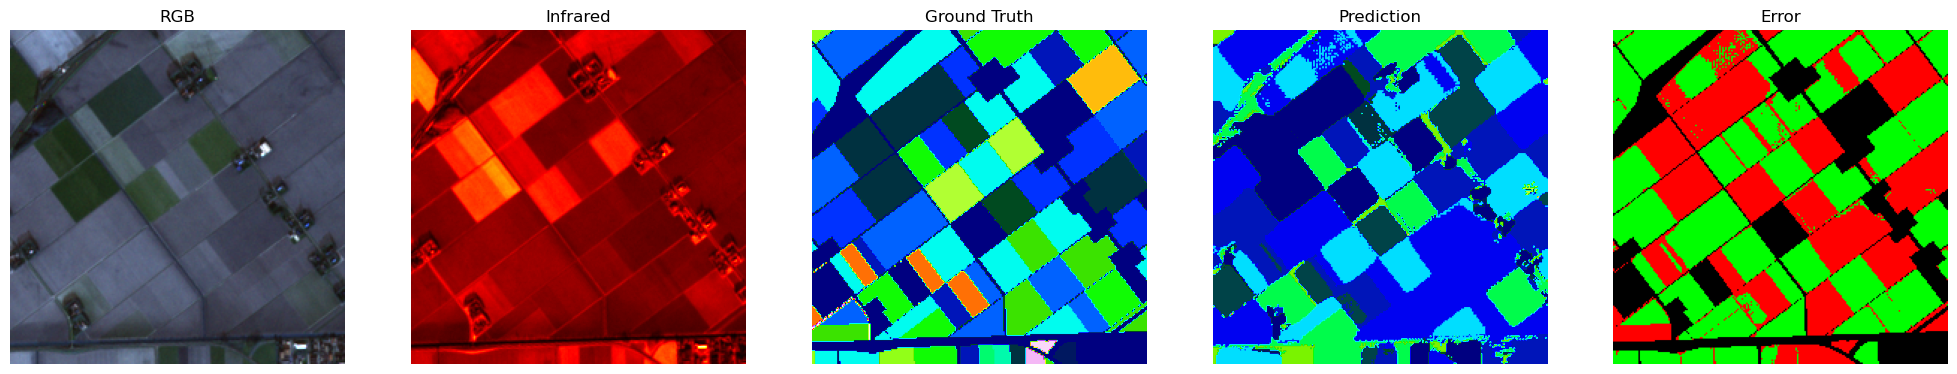

In [36]:
# set arguments (includes class loss weights) and train the model
args = mock.Mock()
args.n_epoch_test = int(1)
args.cuda = gpu_available

args.n_class      = 77
args.n_channel    = 28
args.conv_width   = [64,64,128,128,256,128]
args.dconv_width  = [128,64,128,64]

args.ignore_index = 0 # index of the nodata value

weights = torch.ones(76)
weights[1] = 2.0 # grasland, blijvend
weights[2] = 1.5 # grasland, tijdelijk

args.weights      = weights

args.n_epoch    = 2
args.batch_size = 4
args.lr         = 5e-4 # TODO improve lr schedule?

trained_model = train_full(args)

In [ ]:
# TODO fine-tune the model training, e.g. improve lr schedule, more data augmentation

In [37]:
trained_model

SegNet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (c1): Sequential(
    (0): Conv2d(28, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (c2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (c3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (c4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=ref

In [38]:
# save trained model for inference
torch.save(trained_model.state_dict(), 'rvo_crops_segnet_224x224x28_77classes_2epochs_model_parameters.pt')
torch.save(trained_model, 'rvo_crops_segnet_224x224x28_77classes_2epochs_model_full.pt')

In [45]:
# use a sample training tile to derive a traced (TorchScript) version of the trained model
tile_index = 1
tile, gt = tile_loader(tile_index, train=True, cuda=gpu_available)

traced_model = torch.jit.trace(trained_model, tile[None,:,:,:])

In [46]:
traced_model

SegNet(
  original_name=SegNet
  (maxpool): MaxPool2d(original_name=MaxPool2d)
  (unpool): MaxUnpool2d(original_name=MaxUnpool2d)
  (c1): Sequential(
    original_name=Sequential
    (0): Conv2d(original_name=Conv2d)
    (1): BatchNorm2d(original_name=BatchNorm2d)
    (2): ReLU(original_name=ReLU)
  )
  (c2): Sequential(
    original_name=Sequential
    (0): Conv2d(original_name=Conv2d)
    (1): BatchNorm2d(original_name=BatchNorm2d)
    (2): ReLU(original_name=ReLU)
  )
  (c3): Sequential(
    original_name=Sequential
    (0): Conv2d(original_name=Conv2d)
    (1): BatchNorm2d(original_name=BatchNorm2d)
    (2): ReLU(original_name=ReLU)
  )
  (c4): Sequential(
    original_name=Sequential
    (0): Conv2d(original_name=Conv2d)
    (1): BatchNorm2d(original_name=BatchNorm2d)
    (2): ReLU(original_name=ReLU)
  )
  (c5): Sequential(
    original_name=Sequential
    (0): Conv2d(original_name=Conv2d)
    (1): BatchNorm2d(original_name=BatchNorm2d)
    (2): ReLU(original_name=ReLU)
  )
  (c6

In [48]:
traced_model.state_dict()

OrderedDict([('c1.0.weight',
              tensor([[[[ 5.0486e-02, -2.2572e-02,  6.4402e-02],
                        [ 8.1433e-02, -1.9716e-02, -1.2234e-02],
                        [-5.5333e-03,  1.0313e-01,  2.3289e-03]],
              
                       [[-1.0097e-01, -1.0303e-01, -1.9680e-02],
                        [-5.4184e-02,  4.7375e-02,  3.2863e-03],
                        [-2.4540e-02, -7.6320e-02,  3.1908e-03]],
              
                       [[-1.3092e-02,  5.8907e-02,  7.3961e-02],
                        [ 3.7002e-02,  1.3115e-02, -4.3659e-02],
                        [ 7.8868e-02, -2.3800e-03,  3.4096e-03]],
              
                       ...,
              
                       [[ 4.1352e-03,  5.6629e-02, -2.8678e-02],
                        [ 8.1103e-02,  1.2882e-02,  1.5818e-01],
                        [ 3.5328e-02, -5.7031e-02,  8.0429e-02]],
              
                       [[ 7.3732e-02, -2.3683e-02,  5.7222e-02],
                   

In [47]:
# save the traced TorchScript model (can be loaded into libtorch (C++))
traced_model.save('rvo_crops_segnet_224x224x28_77classes_2epochs_model_full_traced.pt')